# Movie Recommendation Engine

**Goal**
1. Understand what is a recommendation engine and what kind of data is needed to conduct the analysis

2. Understand three types of recommendation engine:\
    (1) Content-based recommendation system\
    (2) Collaborative-filtering\
    (3) Hybrid recommendation system
    
3. Leverage the above knowledge to build movie recommendation engines using different methods

**Data**

To build a recommendation system, the data(feedback data) to be used is either explict or implicit. An explicit data directly has user's rating information while implicit data contains user's using behavior and actions which can also provide enough information for us to build a recommendation system.

The data I'm using here is provided by Datacamp, which is an explicit dataset, having the information of user id, movie's titles and user's ratings. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations

In [2]:
ratings_df = pd.read_csv('user_ratings.csv')
print('Dataset Overview: ')
print(ratings_df.head(5))

print('Data Columns: ')
print(ratings_df.info())

print('# of Ratings and Genres:')
print(ratings_df[['rating', 'genres']].nunique())

Dataset Overview: 
   userId  movieId  rating   timestamp             title  \
0       1        1     4.0   964982703  Toy Story (1995)   
1       5        1     4.0   847434962  Toy Story (1995)   
2       7        1     4.5  1106635946  Toy Story (1995)   
3      15        1     2.5  1510577970  Toy Story (1995)   
4      17        1     4.5  1305696483  Toy Story (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1  Adventure|Animation|Children|Comedy|Fantasy  
2  Adventure|Animation|Children|Comedy|Fantasy  
3  Adventure|Animation|Children|Comedy|Fantasy  
4  Adventure|Animation|Children|Comedy|Fantasy  
Data Columns: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  floa

In [3]:
ratings_df['rating'].value_counts().sort_index()

0.5     1370
1.0     2811
1.5     1791
2.0     7551
2.5     5550
3.0    20047
3.5    13136
4.0    26818
4.5     8551
5.0    13211
Name: rating, dtype: int64

## Non-personalized Recommendations

### 1. By the popularity

In [4]:
# Count the occurence of each movie title
movie_popularity = ratings_df['title'].value_counts()

# Obtain the top five common movies
print(movie_popularity.head(5).index)

Index(['Forrest Gump (1994)', 'Shawshank Redemption, The (1994)',
       'Pulp Fiction (1994)', 'Silence of the Lambs, The (1991)',
       'Matrix, The (1999)'],
      dtype='object')


The initial analysis tells us that the movie 'Forrest Gump (1994)' is the most rated movie among the entire dataset. To get a more accurate recommendation, explicit data column 'rating' is used in the next step.

### 2. By the average ratings

In [5]:
# Find the mean of the ratings of each title
avg_ratings_df = ratings_df[['title','rating']].groupby('title').mean()

# Sort the average ratings from highest to lowest by rating
avg_ratings_df.sort_values(by='rating', ascending=False).head(5)

,rating
title,
Gena the Crocodile (1969),5.0
True Stories (1986),5.0
Cosmic Scrat-tastrophe (2015),5.0
Love and Pigeons (1985),5.0
Red Sorghum (Hong gao liang) (1987),5.0


After finding the average rating in given to each title, the result was showing above. However, since not every movies were rated by the same amount of people, the result might be affected by the number of user who had rated on the movie, that is in other words, the data might be affected by skewness. Therefore, in the next step, the recommendaion is going to be improved by setting the thredshold and reducing the skewness of the data.

In [6]:
# Create a list of only movies appearing > 50 times in the dataset
movie_popularity = ratings_df['title'].value_counts()
popular_movies = movie_popularity[movie_popularity.values>50].index

# Filter the popular movies from original data
popular_movies_rakings = ratings_df[ratings_df['title'].isin(popular_movies)]

# Find the top 5 movies base on their average ratings
popular_movies_rakings[['title','rating']].groupby('title').mean().sort_values(by='rating', ascending=False).head(5)

,rating
title,
"Shawshank Redemption, The (1994)",4.429022
"Godfather, The (1972)",4.289062
Fight Club (1999),4.272936
Cool Hand Luke (1967),4.271930
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964),4.268041


### 3. By finding all pairs of movies

In [7]:
# create a function to find all permutations of movie pairs
def find_movie_pairs(x):
    pairs = pd.DataFrame(list(permutations(x,2)), columns = ['movie_a', 'movie_b'])
    return pairs

# apply the function to the dataset grouping by userId
movie_combinations = ratings_df.groupby('userId')['title'].apply(find_movie_pairs).reset_index(drop = True)
print(movie_combinations)

                   movie_a                           movie_b
0         Toy Story (1995)           Grumpier Old Men (1995)
1         Toy Story (1995)                       Heat (1995)
2         Toy Story (1995)       Seven (a.k.a. Se7en) (1995)
3         Toy Story (1995)        Usual Suspects, The (1995)
4         Toy Story (1995)        From Dusk Till Dawn (1996)
...                    ...                               ...
60793295         31 (2016)                 Gen-X Cops (1999)
60793296         31 (2016)                  Bloodmoon (1997)
60793297         31 (2016)  Sympathy for the Underdog (1971)
60793298         31 (2016)                     Hazard (2005)
60793299         31 (2016)                Blair Witch (2016)

[60793300 rows x 2 columns]


In [20]:
# Calculate the frequency of occurence for each pair
combination_counts = movie_combinations.groupby(['movie_a','movie_b']).size()
combination_counts_df = combination_counts.to_frame(name = 'size').reset_index()
print(combination_counts_df.head())

      movie_a                                     movie_b  size
0  '71 (2014)                 (500) Days of Summer (2009)     1
1  '71 (2014)                  10 Cloverfield Lane (2016)     1
2  '71 (2014)                            127 Hours (2010)     1
3  '71 (2014)  13 Assassins (Jûsan-nin no shikaku) (2010)     1
4  '71 (2014)                             13 Hours (2016)     1


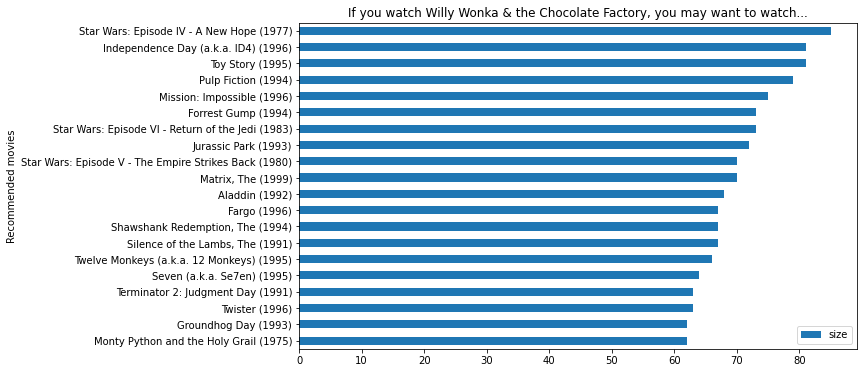

In [9]:
# Take movie 'Willy Wonka & the Chocolate Factory' as example

# Sort the counts of pairs from higest to lowest
pair_counts_sorted = combination_counts_df.sort_values(by='size', ascending=False)

# Find the movies most frequently watched by people who watch The Chocolate Factory
Choc_df = pair_counts_sorted[pair_counts_sorted['movie_a']== 'Willy Wonka & the Chocolate Factory (1971)']

# Plot the result
Choc_df.head(20).plot.barh(x='movie_b', figsize = (10,6))
plt.gca().invert_yaxis()
plt.title('If you watch Willy Wonka & the Chocolate Factory, you may want to watch...')
plt.ylabel('Recommended movies')
plt.show()

In [10]:
def recommend_movie_by_pairs(movie_name):
    df = pair_counts_sorted[pair_counts_sorted['movie_a']== movie_name]
    df.head(20).plot.barh(x='movie_b', figsize = (10,6))
    plt.gca().invert_yaxis()
    plt.title(f'If you watch {movie_name}, you may want to watch...')
    plt.ylabel('Recommended movies')
    plt.show()

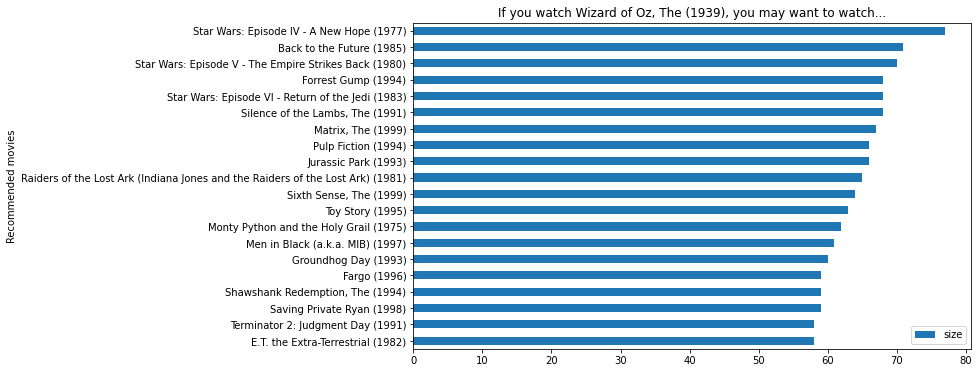

In [11]:
recommend_movie_by_pairs('Wizard of Oz, The (1939)')

In [18]:
def recommend_try(movie_name):
    movie_name = movie_name.lower()
    possible_movie = list(set([x for x in pair_counts_sorted['movie_a'] if movie_name in str(x.lower())]))
    #df = pair_counts_sorted[pair_counts_sorted['movie_a'].isin(possible_movie)]
    #df = df.groupby('movie_a').head(10)
    for movie in possible_movie:
        df = pair_counts_sorted[pair_counts_sorted['movie_a'] == movie]
        df.head(10).plot.barh(x='movie_b', figsize = (8,3))
        plt.gca().invert_yaxis()
        plt.title(f'If you watch {movie}, you may want to watch...')
        plt.ylabel('Recommended movies')
        plt.show()

In [13]:
def recommend_try2(movie_name):
    movie_name = movie_name.lower()
    possible_movie = list(set([x for x in pair_counts_sorted['movie_a'] if movie_name in str(x.lower())]))
    #df = pair_counts_sorted[pair_counts_sorted['movie_a'].isin(possible_movie)]
    #df = df.groupby('movie_a').head(10)
    for movie in possible_movie:
        df = pair_counts_sorted[pair_counts_sorted['movie_a'] == movie]
        recom_movie = list(df.head(5)['movie_b'])
        print('If you like' + '\033[94m' + f' {movie}' + '\033[0m' + ', you may want to watch' + '\033[1m' + f' {recom_movie}.' + '\033[0m')
        print()

In [14]:
def recommend_try3(movie_name):
    movie_name = movie_name.lower()
    possible_movie = list(set([x for x in pair_counts_sorted['movie_a'] if movie_name in str(x.lower())]))
    df = pair_counts_sorted[pair_counts_sorted['movie_a'].isin(possible_movie)]
    df = df.groupby('movie_a').head(10).reset_index(drop=True)
    return df

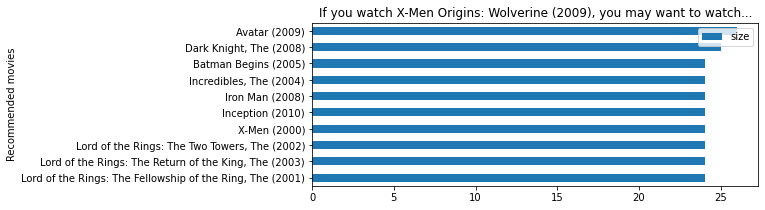

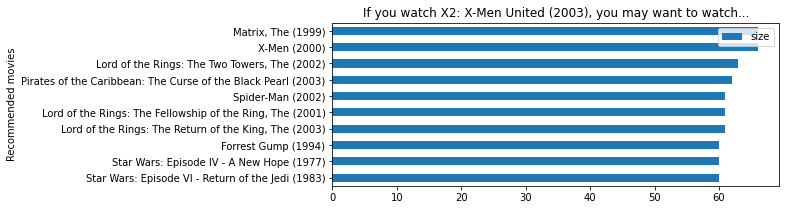

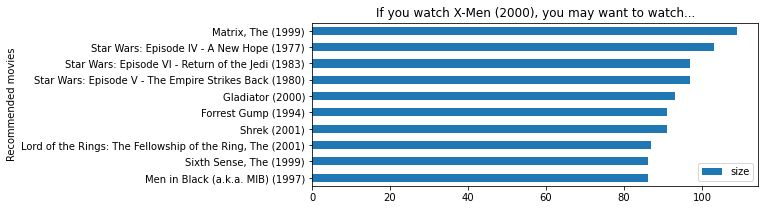

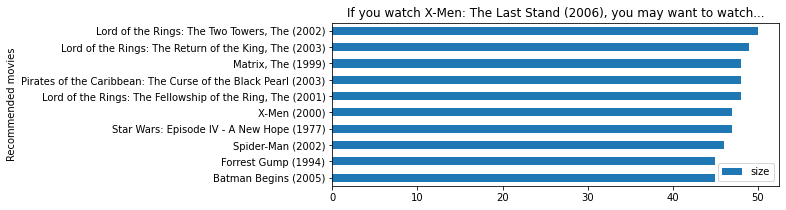

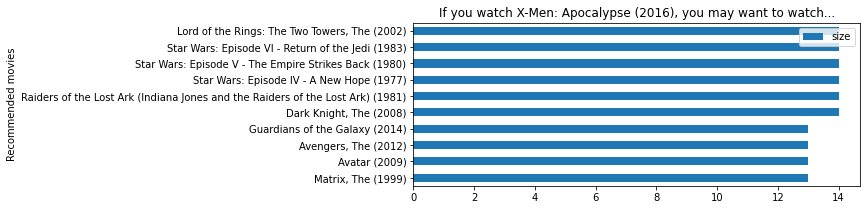

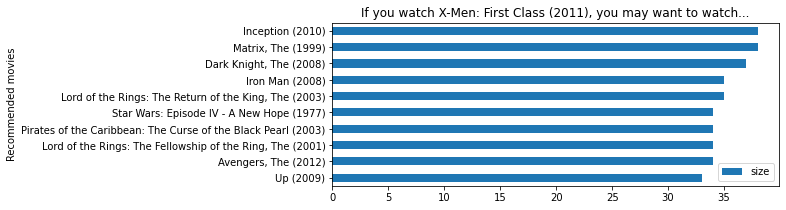

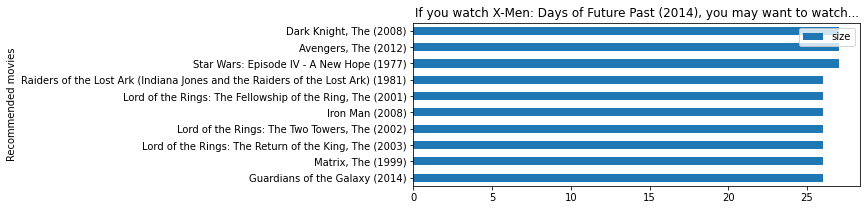

In [19]:
recommend_try('x-men')

In [16]:
recommend_try2('chocolate')

If you like Blood and Chocolate (2007), you may want to watch ['Monsters, Inc. (2001)', 'Matilda (1996)', 'Mask, The (1994)', 'Lost in Austen (2008)', 'Lord of the Rings: The Two Towers, The (2002)'].

If you like Charlie and the Chocolate Factory (2005), you may want to watch ['Forrest Gump (1994)', 'Pirates of the Caribbean: The Curse of the Black Pearl (2003)', 'Shrek (2001)', 'Fight Club (1999)', 'Lord of the Rings: The Two Towers, The (2002)'].

If you like Willy Wonka & the Chocolate Factory (1971), you may want to watch ['Star Wars: Episode IV - A New Hope (1977)', 'Independence Day (a.k.a. ID4) (1996)', 'Toy Story (1995)', 'Pulp Fiction (1994)', 'Mission: Impossible (1996)'].

If you like Bread and Chocolate (Pane e cioccolata) (1973), you may want to watch ['Sixth Sense, The (1999)', 'Spaceballs (1987)', 'Someone to Watch Over Me (1987)', 'Some Kind of Wonderful (1987)', 'So I Married an Axe Murderer (1993)'].

If you like Like Water for Chocolate (Como agua para chocolate) (1

In [17]:
year2017 = recommend_try3('2017')
year2017

,movie_a,movie_b,size
0,Guardians of the Galaxy 2 (2017),Iron Man (2008),22
1,Logan (2017),Forrest Gump (1994),22
2,Logan (2017),"Matrix, The (1999)",22
3,Logan (2017),"Lord of the Rings: The Return of the King, The...",21
4,Logan (2017),"Dark Knight, The (2008)",21
...,...,...,...
1465,It Comes at Night (2017),Unbroken (2014),1
1466,It Comes at Night (2017),Unbreakable (2000),1
1467,It Comes at Night (2017),"Two Days, One Night (Deux jours, une nuit) (2014)",1
1468,It Comes at Night (2017),"Trip to the Moon, A (Voyage dans la lune, Le) ...",1
